# Explore GAA2 Data

The second Global Amphibian Acessment (GAA2) completed in June 2022 and acesses 8,011 species aswell as backcasting redlist categorization for 1980 and 2004. 

**An overview of the IUCN Red List criteria**
<img src="images/redlist_criteria_2022.png" >

*For explanations of terms and concepts in this summary, see: IUCN Standards and Petitions Committee. 2022. Guidelines for Using the IUCN Red List Categories and Criteria. Version 15.1. Prepared by the Standards and Petitions Committee. Downloadable from https://www.iucnredlist.org/documents/RedListGuidelines.pdf*

For extinction risk modeling based on geographic ranges, the **criteria B and E** might be especially interesting. However, it is important to note that red list categorizations are based on a complicated process that may not fully be representable by a simple model. 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from rasterio.features import rasterize

# plotting
import matplotlib.pyplot as plt
import contextily as ctx
import shapely.geometry as geom

In [2]:
# load spacial data 
gaa2 = gpd.read_file('../Data/GAA2/GAA2_allspecies.gdb', rows=20)

In [4]:
gaa2.head()

,sci_name,presence,origin,seasonal,compiler,yrcompiled,citation,generalisd,legend,Shape_Length,Shape_Area,geometry
0,Agalychnis medinae,4,1,1,Grisel Velasquez,2020,IUCN (International Union for Conservation of ...,0,Possibly Extinct,0.370600,0.002628,"MULTIPOLYGON (((-67.68359 10.33905, -67.69001 ..."
1,Agalychnis medinae,1,1,1,Grisel Velasquez,2020,IUCN (International Union for Conservation of ...,0,Extant (resident),12.037778,0.052403,"MULTIPOLYGON (((-68.19222 10.37306, -68.19222 ..."
2,Telmatobius mendelsoni,4,1,1,Kelsey Neam,2017,IUCN (International Union for Conservation of ...,0,Possibly Extinct,0.497784,0.010478,"MULTIPOLYGON (((-71.58104 -13.20094, -71.58300..."
3,Thorius omiltemi,1,1,1,Lauren Warr,2019,IUCN (International Union for Conservation of ...,0,Extant (resident),0.842579,0.010135,"MULTIPOLYGON (((-99.83744 17.62612, -99.83715 ..."
4,Ptychadena perplicata,1,1,1,Evie J Morris,2013,IUCN (International Union for Conservation of ...,0,Extant (resident),35.864748,55.708237,"MULTIPOLYGON (((14.33262 -13.91498, 14.33160 -..."


In [5]:
gdf_i = gaa2.iloc[[4]]
gdf_i['sci_name'].values[0]

'Ptychadena perplicata'

### Calculate habitat variables
Perhaps the most representative habitat cannot be derived form GAA2 data. Also calculate habitat specialist variable.

### Look at climate niche variable
**1980 - 2004**

In [3]:
# load raster data
f = pd.read_csv('archive/gaa2_climate_2004_5y.csv')
# fix up some stuff
for col in f.columns:
    if col.endswith('nichefrac_2004'):
        f.loc[f[col].values == '', col] = np.nan
        f[col] = np.array(f[col].values, dtype=float)

In [4]:
# check count of climate niche fraction under different thresholds
for var in ['MAT', 'MTWM', 'MTCM', 'AP', 'PDQ']:
    print(var)
    for thesh in [0.1, 0.5, 0.8, 0.9, 0.95, 0.99, 1.0]:
        count = f['sci_name'].loc[f[var + '_nichefrac_2004'].values <= thesh].count()
        print('threshold', thesh, 'count', count)

MAT
threshold 0.1 count 15
threshold 0.5 count 30
threshold 0.8 count 148
threshold 0.9 count 343
threshold 0.95 count 528
threshold 0.99 count 844
threshold 1.0 count 11939
MTWM
threshold 0.1 count 18
threshold 0.5 count 34
threshold 0.8 count 153
threshold 0.9 count 334
threshold 0.95 count 546
threshold 0.99 count 918
threshold 1.0 count 11939
MTCM
threshold 0.1 count 9
threshold 0.5 count 21
threshold 0.8 count 114
threshold 0.9 count 286
threshold 0.95 count 448
threshold 0.99 count 763
threshold 1.0 count 11939
AP
threshold 0.1 count 57
threshold 0.5 count 108
threshold 0.8 count 359
threshold 0.9 count 808
threshold 0.95 count 1461
threshold 0.99 count 2587
threshold 1.0 count 11939
PDQ
threshold 0.1 count 63
threshold 0.5 count 121
threshold 0.8 count 483
threshold 0.9 count 1128
threshold 0.95 count 1841
threshold 0.99 count 2888
threshold 1.0 count 11939


see how it is related to category changes due to climate change between 1980 and 2004

In [5]:
# load species data
s = pd.read_csv('../Data/GAA2/All_amphibians_tabular_data.CSV')

In [6]:
s.keys()

Index(['Order', 'Family', 'Species Name', '1980 GAA2 Red List Category',
       '2004 GAA2 Red List Category', '1980-2004 Genuine Change?',
       '1980-2004 Primary Driver', 'Grouped 1980-2004 Primary Driver',
       '1980-2004 Genuine downlisting due to conservation',
       '2022 GAA2 Red List Category', '2022 Red List Criteria',
       '2004-2022 Genuine Change?', ' 2004-2022 Primary Driver',
       'Grouped 2004-2022 Primary Driver',
       '2004-2022 Genuine downlisting due to conservation', 'Afrotropical',
       'Australasian/Oceanian', 'Indomalayan', 'Nearctic', 'Neotropical',
       'Palearctic', 'Egg Laying', 'Free Living Larval Stage', 'Live Birth ',
       'Water Breeding'],
      dtype='object')

In [7]:
# for geo, get the temperature and precipitation data for grid cells
T_window, geo_mask, cell_coefs = prep_for_gridcalc(T.Tavg, geo)

NameError: name 'prep_for_gridcalc' is not defined

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
# Some general stats
# count unique species ('sci_name') in f
print('num of species acessed in GAA2:', f['sci_name'].nunique())
print('num of species with acessed changed 1980-2004/2004-1980:', s['Species Name'].nunique())

# missing values in 1980 RL category
print('Data deficient species 1980:', s['Species Name'].loc[s['1980 GAA2 Red List Category'].str.contains('DD')].count())
print('Data deficient species 2004:', s['Species Name'].loc[s['2004 GAA2 Red List Category'].str.contains('DD')].count())
print('Data deficient species 2022:', s['Species Name'].loc[s['2022 GAA2 Red List Category'].str.contains('DD')].count())

num of species acessed in GAA2: 7952
num of species with acessed changed 1980-2004/2004-1980: 8011
Data deficient species 1980: 909
Data deficient species 2004: 909
Data deficient species 2022: 909


In [10]:
# check if s['1980-2004 Genuine Change?'].values contains "Genuine" as part of the string
cc = s['Species Name'].loc[s['1980-2004 Genuine Change?'].str.contains('Genuine') & 
      s['1980-2004 Primary Driver'].str.contains('Climate change')]
print('number of species with genuine change due to climate change:', cc.count())
print('species names:', cc.values)
print('lines', cc.index)

# get these lines from the original data
# f.loc[f['sci_name'].isin(cc.values)]

number of species with genuine change due to climate change: 6
species names: ['Batrachoseps minor' 'Cophixalus neglectus' 'Cophixalus nubicola'
 'Cornufer citrinospilus' 'Eleutherodactylus unicolor' 'Uperoleia martini']
lines Index([793, 1673, 1675, 1746, 2522, 7849], dtype='int64')


In [84]:
s['Species Name'].loc[s['1980-2004 Genuine Change?'].str.contains('uplisted')].count()

482

From the six species downlisted with climate change listed as primary driver, only two exceeded their "climate niche" (in precipitation in driest quarter)!

Check out how many of the species with massive exceedance of climate niche are also in the genuine change list:

In [85]:
# get fraction of f that is also present in s
fcomp = f.loc[f['sci_name'].isin(s['Species Name'].values)]
percentages = []

for thesh in np.round(np.arange(0.1, 1.1, 0.1),1):
    # get list with species names with niche fraction less than thesh
    nicheloosers = np.array([])
    for var in ['MAT', 'MTWM', 'MTCM', 'AP', 'PDQ']:
        names = fcomp['sci_name'].loc[fcomp[var + '_nichefrac_2004'].values <= thesh].values
        # combine names with prewious names, avoiding duplicates
        nicheloosers = np.unique(np.concatenate([nicheloosers, names]))

    # find species with genuine change
    change = s.loc[s['1980-2004 Genuine Change?'].str.contains('uplisted')]

    # find which of these are also nicheloosers
    count = change['Species Name'].loc[change['Species Name'].isin(nicheloosers)].unique().shape[0]
    percentages.append(count/len(nicheloosers)*100)

    print('threshold', thesh, '| count', len(nicheloosers), 'RL change of those', count, 'in percent:', round(count/len(nicheloosers)*100,2))

threshold 0.1 | count 108 RL change of those 12 in percent: 11.11
threshold 0.2 | count 108 RL change of those 12 in percent: 11.11
threshold 0.3 | count 120 RL change of those 14 in percent: 11.67
threshold 0.4 | count 136 RL change of those 14 in percent: 10.29
threshold 0.5 | count 209 RL change of those 19 in percent: 9.09
threshold 0.6 | count 290 RL change of those 30 in percent: 10.34
threshold 0.7 | count 423 RL change of those 42 in percent: 9.93
threshold 0.8 | count 728 RL change of those 65 in percent: 8.93
threshold 0.9 | count 1484 RL change of those 107 in percent: 7.21
threshold 1.0 | count 7848 RL change of those 476 in percent: 6.07


In [86]:
var_codes = ['MAT', 'MTWM', 'MTCM', 'AP', 'PDQ']
# dict with percentages
percentages_vars = {var_code:[] for var_code in var_codes}

for thesh in np.round(np.arange(0.1, 1.1, 0.1),1):
    print('Threshold:', thesh)
    for var_code in var_codes:
        # get list with species names with niche fraction less than thesh
        nicheloosers = fcomp['sci_name'].loc[fcomp[var_code + '_nichefrac_2004'].values <= thesh].values
        # combine names with previous names, avoiding duplicates
        nicheloosers = np.unique(nicheloosers)

        # find species with genuine change
        change = s.loc[s['1980-2004 Genuine Change?'].str.contains('uplisted')]

        # find which of these are also nicheloosers
        count = change['Species Name'].loc[change['Species Name'].isin(nicheloosers)].unique().shape[0]
        percentage = round(count/len(nicheloosers)*100,2)
        percentages_vars[var_code].append(percentage)
        print(f'Variable: {var_code} | Count: {len(nicheloosers)} | RL change of those: {count} | In percent: {percentage}')

# Total percentage
total_change = s.loc[s['1980-2004 Genuine Change?'].str.contains('uplisted')]
total_count = total_change['Species Name'].loc[total_change['Species Name'].isin(total_nicheloosers)].unique().shape[0]
total_percentage = round(total_count/len(total_nicheloosers)*100,2)
print(f'Total | Count: {len(total_nicheloosers)} | RL change of those: {total_count} | In percent: {total_percentage}')

Threshold: 0.1
Variable: MAT | Count: 14 | RL change of those: 0 | In percent: 0.0
Variable: MTWM | Count: 15 | RL change of those: 0 | In percent: 0.0
Variable: MTCM | Count: 8 | RL change of those: 0 | In percent: 0.0
Variable: AP | Count: 52 | RL change of those: 8 | In percent: 15.38
Variable: PDQ | Count: 57 | RL change of those: 11 | In percent: 19.3
Threshold: 0.2
Variable: MAT | Count: 14 | RL change of those: 0 | In percent: 0.0
Variable: MTWM | Count: 15 | RL change of those: 0 | In percent: 0.0
Variable: MTCM | Count: 8 | RL change of those: 0 | In percent: 0.0
Variable: AP | Count: 52 | RL change of those: 8 | In percent: 15.38
Variable: PDQ | Count: 57 | RL change of those: 11 | In percent: 19.3
Threshold: 0.3
Variable: MAT | Count: 15 | RL change of those: 0 | In percent: 0.0
Variable: MTWM | Count: 15 | RL change of those: 0 | In percent: 0.0
Variable: MTCM | Count: 9 | RL change of those: 0 | In percent: 0.0
Variable: AP | Count: 54 | RL change of those: 8 | In percent:

Text(0, 0.5, 'percentage with genuine category change')

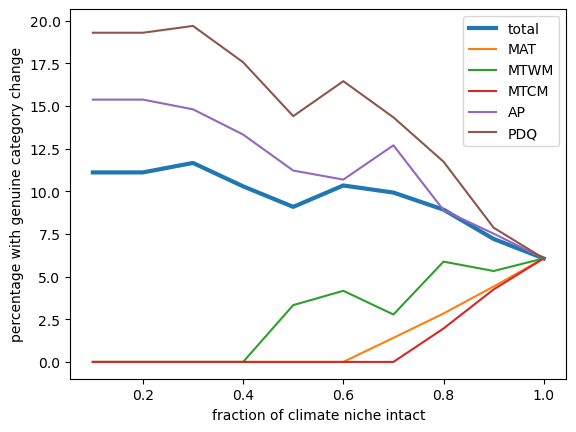

In [87]:
# plot relationship between threshold and percentage of nicheloosers that are also RL change)
plt.plot(np.arange(0.1, 1.1, 0.1), percentages, label = 'total', linewidth=3)
plt.plot(np.arange(0.1, 1.1, 0.1), percentages_vars['MAT'], label = 'MAT')
plt.plot(np.arange(0.1, 1.1, 0.1), percentages_vars['MTWM'], label = 'MTWM')
plt.plot(np.arange(0.1, 1.1, 0.1), percentages_vars['MTCM'], label = 'MTCM')
plt.plot(np.arange(0.1, 1.1, 0.1), percentages_vars['AP'], label = 'AP')
plt.plot(np.arange(0.1, 1.1, 0.1), percentages_vars['PDQ'], label = 'PDQ')
plt.legend()
plt.title('cumulative histogram: genuine change 1980-2004/ climate niche')
plt.xlabel('fraction of climate niche intact')
plt.ylabel('percentage with genuine category change')


**2004 - 2022**

In [17]:
# check if s['1980-2004 Genuine Change?'].values contains "Genuine" as part of the string
cc = s['Species Name'].loc[s['2004-2022 Genuine Change?'].str.contains('Genuine') & 
      s[' 2004-2022 Primary Driver'].str.contains('Climate change')]
print('number of species with genuine change due to climate change:', cc.count())
# get these lines from the original data
f.loc[f['sci_name'].isin(cc.values)]

number of species with genuine change due to climate change: 119


,Unnamed: 0,sci_name,presence,origin,seasonal,compiler,yrcompiled,citation,generalisd,legend,Shape_Length,Shape_Area,MAT_nichefrac_2004,MTWM_nichefrac_2004,MTCM_nichefrac_2004,AP_nichefrac_2004,PDQ_nichefrac_2004
95,95,Tepuihyla luteolabris,1,1,1,Grisel Velasquez,2019,IUCN (International Union for Conservation of ...,0,Extant (resident),0.625969,0.007106,1.0,1.0,1.0,1.000000,1.000000
104,104,Sooglossus thomasseti,1,1,1,Ariadne Angulo,2012,IUCN (International Union for Conservation of ...,0,Extant (resident),0.364163,0.001781,1.0,1.0,1.0,1.000000,1.000000
119,119,Myersiohyla inparquesi,3,1,1,Grisel Velasquez,2019,IUCN (International Union for Conservation of ...,0,Possibly Extant (resident),0.526644,0.009299,1.0,1.0,1.0,1.000000,1.000000
120,120,Myersiohyla inparquesi,1,1,1,Grisel Velasquez,2019,IUCN (International Union for Conservation of ...,0,Extant (resident),0.022575,0.000033,1.0,1.0,1.0,1.000000,1.000000
182,182,Sooglossus sechellensis,1,1,1,Ariadne Angulo,2012,IUCN (International Union for Conservation of ...,0,Extant (resident),0.497975,0.002334,1.0,1.0,1.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12039,12039,Ambystoma cingulatum,4,1,1,Lauren Warr,2021,IUCN (International Union for Conservation of ...,0,Possibly Extinct,42.543921,3.947943,1.0,1.0,1.0,1.000000,1.000000
12052,12052,Anomaloglossus apiau,1,1,1,Sheila Andrade,2021,IUCN (International Union for Conservation of ...,0,Extant (resident),0.597548,0.010816,1.0,1.0,1.0,1.000000,1.000000
12053,12053,Anomaloglossus apiau,1,1,1,Sheila Andrade,2021,IUCN (International Union for Conservation of ...,0,Extant (resident),1.869183,0.103105,1.0,1.0,1.0,1.000000,1.000000
12088,12088,Desmognathus imitator,1,1,1,Lauren Warr,2021,IUCN (International Union for Conservation of ...,0,Extant (resident),4.228113,0.367937,1.0,1.0,1.0,1.000000,0.928459


Text(0, 0.5, 'percentage with genuine category change')

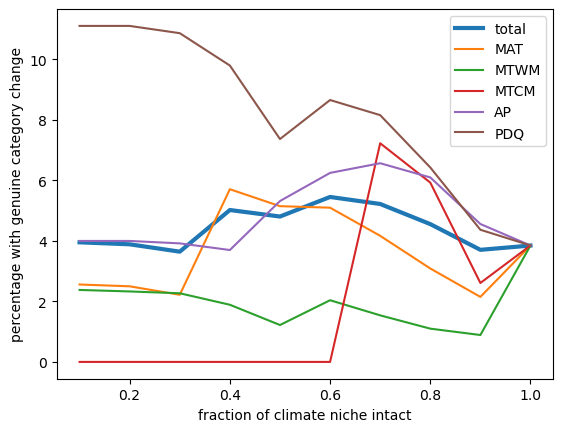

In [69]:
# load raster data
f = pd.read_csv('archive/gaa2_climate_2021_5y.csv')
# fix up some stuff
for col in f.columns:
    if col.endswith('nichefrac_2021'):
        f.loc[f[col].values == '', col] = np.nan
        f[col] = np.array(f[col].values, dtype=float)

# get fraction of f that is also present in s
fcomp = f.loc[f['sci_name'].isin(s['Species Name'].values)]
percentages = []

for thesh in np.round(np.arange(0.1, 1.1, 0.1),1):
    # get list with species names with niche fraction less than thesh
    nicheloosers = np.array([])
    for var in ['MAT', 'MTWM', 'MTCM', 'AP', 'PDQ']:
        names = fcomp['sci_name'].loc[fcomp[var + '_nichefrac_2021'].values <= thesh].values
        # combine names with prewious names, avoiding duplicates
        nicheloosers = np.unique(np.concatenate([nicheloosers, names]))

    # find species with genuine change
    change = s.loc[s['2004-2022 Genuine Change?'].str.contains('uplisted')]

    # find which of these are also nicheloosers
    count = change['Species Name'].loc[change['Species Name'].isin(nicheloosers)].unique().shape[0]
    percentages.append(count/len(nicheloosers)*100)

    # print('threshold', thesh, '| count', len(nicheloosers), 'RL change of those', count, 'in percent:', round(count/len(nicheloosers)*100,2))
    
    
# calculate seperately
var_codes = ['MAT', 'MTWM', 'MTCM', 'AP', 'PDQ']
# dict with percentages
percentages_vars = {var_code:[] for var_code in var_codes}

for thesh in np.round(np.arange(0.1, 1.1, 0.1),1):
    # print('Threshold:', thesh)
    for var_code in var_codes:
        # get list with species names with niche fraction less than thesh
        nicheloosers = fcomp['sci_name'].loc[fcomp[var_code + '_nichefrac_2021'].values <= thesh].values
        # combine names with previous names, avoiding duplicates
        nicheloosers = np.unique(nicheloosers)

        # find species with genuine change
        change = s.loc[s['2004-2022 Genuine Change?'].str.contains('uplisted')]

        # find which of these are also nicheloosers
        count = change['Species Name'].loc[change['Species Name'].isin(nicheloosers)].unique().shape[0]
        percentage = round(count/len(nicheloosers)*100,2)
        percentages_vars[var_code].append(percentage)
        # print(f'Variable: {var_code} | Count: {len(nicheloosers)} | RL change of those: {count} | In percent: {percentage}')

# Total percentage
total_change = s.loc[s['2004-2022 Genuine Change?'].str.contains('uplisted')]
total_count = total_change['Species Name'].loc[total_change['Species Name'].isin(total_nicheloosers)].unique().shape[0]
total_percentage = round(total_count/len(total_nicheloosers)*100,2)
# print(f'Total | Count: {len(total_nicheloosers)} | RL change of those: {total_count} | In percent: {total_percentage}')    
    
# plot relationship between threshold and percentage of nicheloosers that are also RL change)
plt.plot(np.arange(0.1, 1.1, 0.1), percentages, label = 'total', linewidth=3)
plt.plot(np.arange(0.1, 1.1, 0.1), percentages_vars['MAT'], label = 'MAT')
plt.plot(np.arange(0.1, 1.1, 0.1), percentages_vars['MTWM'], label = 'MTWM')
plt.plot(np.arange(0.1, 1.1, 0.1), percentages_vars['MTCM'], label = 'MTCM')
plt.plot(np.arange(0.1, 1.1, 0.1), percentages_vars['AP'], label = 'AP')
plt.plot(np.arange(0.1, 1.1, 0.1), percentages_vars['PDQ'], label = 'PDQ')
plt.title('2004-2022')
plt.legend()
plt.xlabel('fraction of climate niche intact')
plt.ylabel('percentage with genuine category change')

### plot examples
get 10 examples with 0.2-0.4, 0.4-0.6, 0.6-0.8 fraction of climate niche intact (total)

In [94]:
# get fraction of f that is also present in s
fcomp = f.loc[f['sci_name'].isin(s['Species Name'].values)]
percentages = []
species_names_threshold = {}

for thesh in np.round(np.arange(0.1, 1.1, 0.1),1):
    # get list with species names with niche fraction less than thesh
    nicheloosers = np.array([])
    for var in ['MAT', 'MTWM', 'MTCM', 'AP', 'PDQ']:
        names = fcomp['sci_name'].loc[fcomp[var + '_nichefrac_2004'].values <= thesh].values
        # combine names with prewious names, avoiding duplicates
        nicheloosers = np.unique(np.concatenate([nicheloosers, names]))

    # find species with genuine change
    change = s.loc[s['1980-2004 Genuine Change?'].str.contains('uplisted')]

    # find which of these are also nicheloosers
    count = change['Species Name'].loc[change['Species Name'].isin(nicheloosers)].unique().shape[0]
    percentages.append(count/len(nicheloosers)*100)
    species_names_threshold[thesh] = nicheloosers
    # print('threshold', thesh, '| count', len(nicheloosers), 'RL change of those', count, 'in percent:', round(count/len(nicheloosers)*100,2))
    
# randomly select 10 nicheloosers for each threshold range 0.2 - 0.4, 0.4 - 0.6, 0.6 - 0.8
# select nicheloosers[0.4] which are unique and not in nicheloosers[0.2]
nicheloosers24 = np.setdiff1d(species_names_threshold[0.4], species_names_threshold[0.2])
nicheloosers46 = np.setdiff1d(species_names_threshold[0.6], species_names_threshold[0.4])
nicheloosers68 = np.setdiff1d(species_names_threshold[0.8], species_names_threshold[0.6])

# randomly select 10 species from each of these
np.random.seed(42)
nicheloosers24 = np.random.choice(nicheloosers24, size=10, replace=False)
nicheloosers46 = np.random.choice(nicheloosers46, size=10, replace=False)
nicheloosers68 = np.random.choice(nicheloosers68, size=10, replace=False)

# focus on nicheloosers24[8], find all columns with this species name in f
idx = f.loc[f['sci_name'] == nicheloosers24[8]].index
# plot range maps for these species
# load raster data, load idx
g = gpd.read_file('../Data/GAA2/GAA2_allspecies.gdb', rows=slice(idx[0], idx[-1]))

# plot geometries
g.explore()

(28,)


In [105]:
nicheloosers24[0]

'Amazophrynella xinguensis'

In [92]:
# save x, a dictionary of 5 xarray entries, to netcdf
x.to_netcdf('archive/gaa2_climate_2004_5y.nc')

{0.1: array(['Abavorana nazgul', 'Adenomera phonotriccus', 'Adenomus kandianus',
        'Amolops adicola', 'Amolops mahabharatensis',
        'Aquiloeurycea quetzalanensis', 'Aquiloeurycea scandens',
        'Arthroleptis brevipes', 'Arthroleptis phrynoides',
        'Arthroleptis troglodytes', 'Atelopus coynei',
        'Atelopus longirostris', 'Balebreviceps hillmani',
        'Boana clepsydra', 'Bromeliohyla dendroscarta', 'Bufo bufo',
        'Bufoides meghalayanus', 'Cacosternum capense',
        'Callulops eremnosphax', 'Chaperina fusca',
        'Chiropterotriton infernalis', 'Cophixalus misimae',
        'Cycloramphus juimirim', 'Duttaphrynus hololius',
        'Duttaphrynus melanostictus', 'Eleutherodactylus chlorophenax',
        'Eleutherodactylus gryllus', 'Eleutherodactylus hedricki',
        'Eleutherodactylus locustus', 'Eleutherodactylus semipalmatus',
        'Eleutherodactylus unicolor', 'Eleutherodactylus wightmanae',
        'Ericabatrachus baleensis', 'Gastrotheca

# Realms and Ecological traits

In [35]:
# load gaa2 tabular data
s = pd.read_csv('../Data/GAA2/All_amphibians_tabular_data.CSV')
bio = pd.read_csv('../Data/AmphiBIO/AmphiBIO_v1.csv', encoding='latin1')


In [103]:
# pd.set_option('display.max_columns', None)

# look at the overlap between bio['Species'] and s['Species Name']
# get fraction of bio that is also present in s
print('Species in GAA2 dataset:', s['Species Name'].nunique())
bio_comp = s.loc[s['Species Name'].isin(bio['Species'].values)]
print('species also in AmphiBIO:', bio_comp['Species Name'].count())

# get fraction of s with genuine change
change = s['Species Name'].loc[s['1980-2004 Genuine Change?'].str.contains('uplisted')].count()
# get fraction of s with genuine change in bio_comp
change_comp = bio_comp['Species Name'].loc[bio_comp['1980-2004 Genuine Change?'].str.contains('uplisted')].count()
print('species with genuine change:', change, 'of those in AmphiBIO:', change_comp)


Species in GAA2 dataset: 8011
species also in AmphiBIO: 5706
species with genuine change: 482 of those in AmphiBIO: 399


# Explore Human Preassure maps
## HYDE

In [2]:
# load urban areas, cropland pastures
urban = xr.open_dataset("../Data/HYDE_landuse_pop_1901_2021/landuse-urbanareas_histsoc_annual_1901_2021.nc", decode_coords="all", decode_times=False)
crop = xr.open_dataset("../Data/HYDE_landuse_pop_1901_2021/landuse-totals_histsoc_annual_1901_2021.nc", decode_coords="all", decode_times=False)
pasture = xr.open_dataset("../Data/HYDE_landuse_pop_1901_2021/landuse-pastures_histsoc_annual_1901_2021.nc", decode_coords="all", decode_times=False)

# normalize the years 1901 - 2021
urban['time'] = (urban['time'] + 1901 - pasture['time'][0]).astype(int)
crop['time'] = (crop['time'] + 1901 - pasture['time'][0]).astype(int)
pasture['time'] = (pasture['time'] + 1901 - pasture['time'][0]).astype(int)

# write crs WSG 84 (lon, lat)
urban = urban.rio.write_crs("EPSG:4326")
crop = crop.rio.write_crs("EPSG:4326")
pasture = pasture.rio.write_crs("EPSG:4326")

In [3]:
# load population data
pop = xr.open_dataset('../Data/HYDE_landuse_pop_1901_2021/population_histsoc_30arcmin_annual_1901_2021.nc')
pop = pop.rio.write_crs("EPSG:4326")
# take the logp1 of the population
pop['total-population'] = np.log(pop['total-population'] + 1)


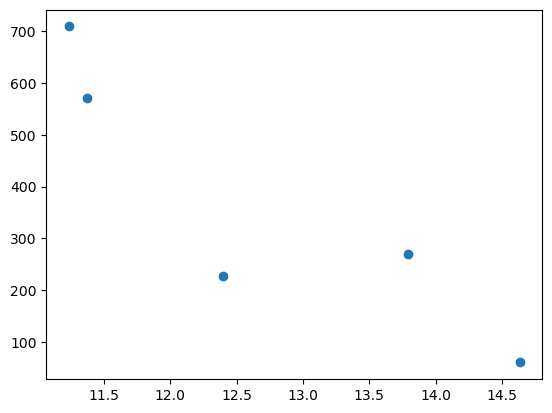

In [14]:
a = [2266268.75, 973302.4791666667, 87015.30269100031, 241506.265625, 75787.7288745667]
b = [60.72018710810025, 269.45562026145075, 569.9146152607608, 227.55822633943453, 708.782367842746]
plt.scatter(np.log(a),b)

pop

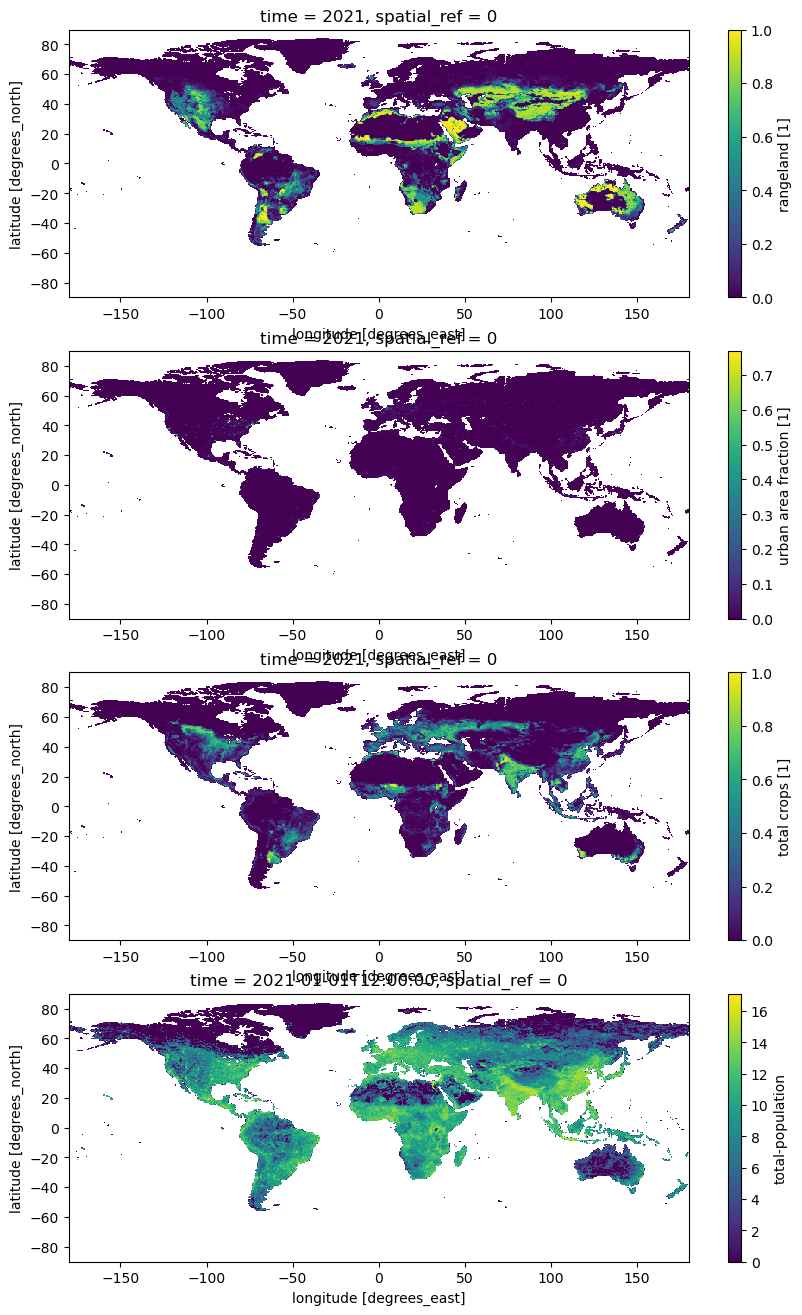

In [4]:
# plot 2021

%matplotlib inline
plt.figure(figsize=(10,16))
plt.subplot(4,1,1)
pasture.sel(time=2021).rangeland.plot.imshow(cmap='viridis', add_colorbar=True)
plt.subplot(4,1,2)
urban.sel(time=2021).urbanareas.plot.imshow(cmap='viridis', add_colorbar=True)
plt.subplot(4,1,3)
crop.sel(time=2021).cropland_total.plot.imshow(cmap='viridis', add_colorbar=True)
plt.subplot(4,1,4)
pop['total-population'].sel(time=pop['time.year']==2021)[0,:,:].plot.imshow(cmap='viridis', add_colorbar=True)

## Accessibility
Weiss et al. (2018), Nelson, A. (2008)

In [6]:
# load travel time to cities for 2015
acc15 = rxr.open_rasterio('../Data/Accessibility/Access2015/travel_time_to_cities_10.tif')

# cut out ocean
acc15 = acc15.where(acc15 < 65535).sel(band=1).sortby('y')
acc15_res = acc15.coarsen(x=50, y=50, boundary='trim').mean()

In [7]:
# load travel time to cities for 2000
acc00 = rxr.open_rasterio('../Data/Accessibility/Access2000/acc_50k.tif')

# cut out ocean
acc00 = acc00.where(acc00 > -10).sel(band=1).sortby('y')
acc00_res = acc00.coarsen(x=50, y=50, boundary='trim').mean()

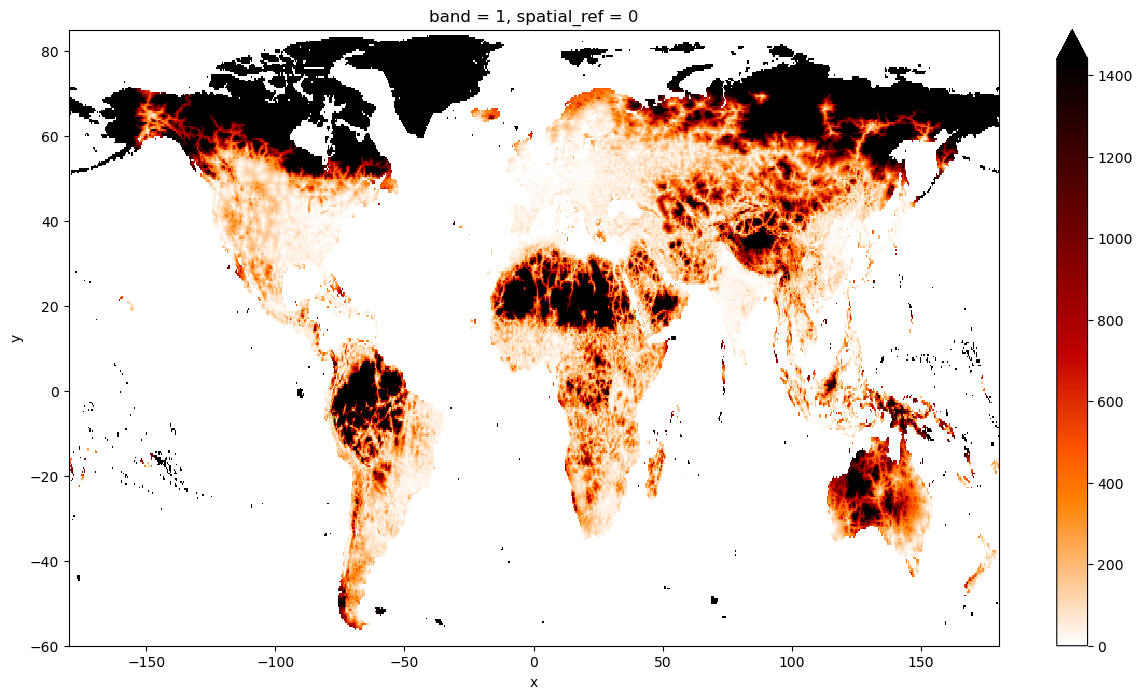

In [7]:
# plot, maximum: 1 day (60 * 24 = 1440 minutes)
plt.figure(figsize=(15,8))
acc15_res.plot.imshow(cmap='gist_heat_r', add_colorbar=True, vmax=1440)

In [8]:
# import geometries
geo = gpd.read_file('../Data/GAA2/GAA2_allspecies.gdb', rows = 100)

In [9]:
range_mean_res = np.zeros(100)
range_mean = np.zeros(100)
range_mean00 = np.zeros(100)
from time import time

from utilities_spacial_vars import GridCalc
t0 = time()
for i in range(100):
    # calc grid
    grid = GridCalc(acc15_res, geo.iloc[[i]], margin = 0.5)
    range_mean_res[i] = grid.calc_average(grid.data_window)
t1 = time()
print('time res:', t1-t0)

for i in range(100):
    grid = GridCalc(acc00, geo.iloc[[i]], margin = 2 * acc15.rio.resolution()[0])
    range_mean00[i] = grid.calc_average(grid.data_window)

t2 = time()
for i in range(100):
    grid = GridCalc(acc15, geo.iloc[[i]], margin = 2 * acc15.rio.resolution()[0])
    range_mean[i] = grid.calc_average(grid.data_window)
t3 = time()
print('time full:', t3-t2)

time res: 1.357349157333374
time full: 5.452155113220215


Text(0, 0.5, 'resampled resolution 0.25°')

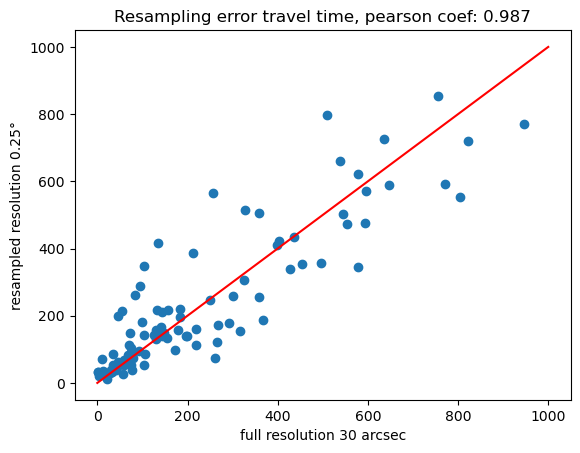

In [11]:
corr = np.round(np.corrcoef(range_mean, range_mean_res)[0,1],3)

plt.scatter(range_mean[range_mean<1000], range_mean_res[range_mean<1000])
plt.plot([0, 1000], [0, 1000], 'r')
plt.title('Resampling error travel time, pearson coef: {}'.format(corr))
plt.xlabel('full resolution 30 arcsec')
plt.ylabel('resampled resolution 0.25°')

In [81]:
grid.mask.sum()

0

transform
| 0.50, 0.00, 8.00|
| 0.00,-0.50, 3.00|
| 0.00, 0.00, 1.00|
out_shape (8, 6)


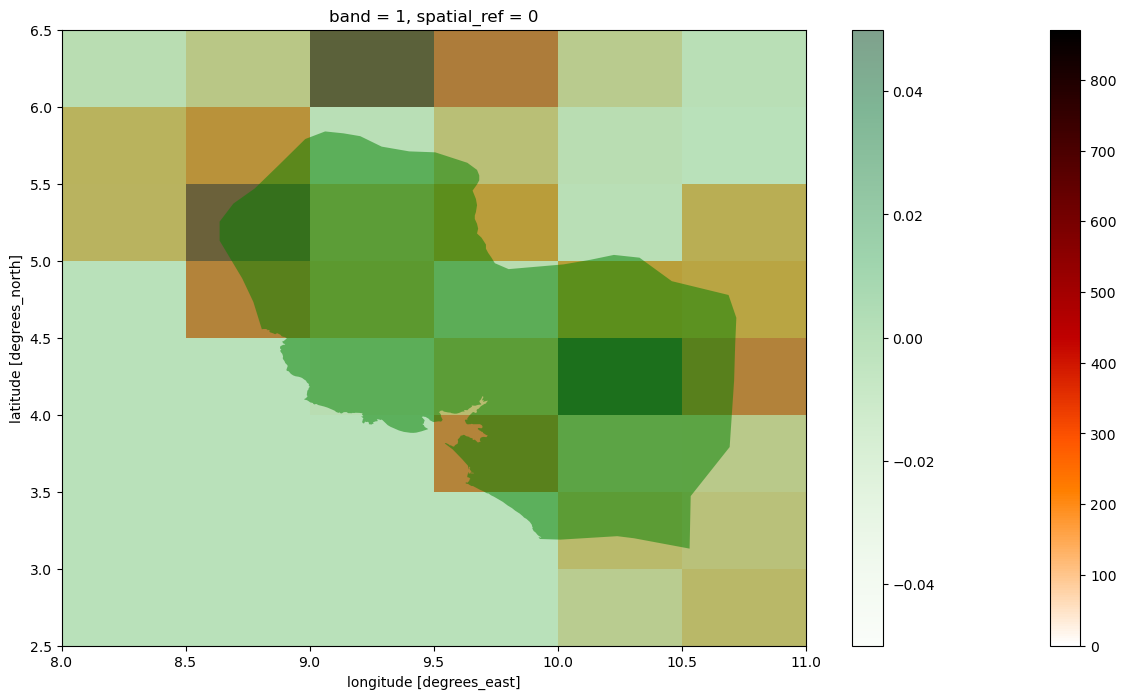

In [137]:
# i = 10
range_mean_res = np.zeros(100)
range_mean = np.zeros(100)

from utilities_spacial_vars import GridCalc

i = 7

# calc grid
# grid = GridCalc(pp, geo.iloc[[i]], margin = 0.5)
grid = GridCalc(acc15_res, geo.iloc[[i]], margin = 0.5)
# range_mean_res[i] = grid.calc_average(grid.data_window)


# plot data window and geometry
plt.figure(figsize=(15,8))
grid.data_window.plot.imshow(cmap='gist_heat_r', add_colorbar=True)
geo.iloc[[i]].plot(ax=plt.gca(), color='green', alpha=0.5)
mask = grid.data_window.copy()
mask.values = grid.mask
# plot mask with alpha = 0.5 on top of data window
mask.plot.imshow(cmap='Greens', add_colorbar=True, alpha=0.5)

geo_mask = rasterize([(geo.iloc[[i]]['geometry'].iloc[0])],
                      transform=grid.data_window.rio.transform(),
                      out_shape=(grid.data_window[grid.lat].shape[0], grid.data_window[grid.lon].shape[0]),  
                      all_touched=True)

print('transform')
print(grid.data_window.rio.transform())
print('out_shape', (grid.data_window[grid.lat].shape[0], grid.data_window[grid.lon].shape[0]))

# ------------------------------------------------
# grid = GridCalc(acc15, geo.iloc[[i]], margin = 2 * acc15.rio.resolution()[0])
# range_mean[i] = grid.calc_average(grid.data_window)

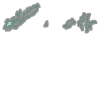

In [104]:
(geo.iloc[[1]]['geometry'].iloc[0])

In [32]:
range_mean

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

# ERA 5 Data

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from rasterio.features import rasterize
from datetime import date, timedelta

# plotting
import matplotlib.pyplot as plt
import contextily as ctx

In [3]:
# load and preprocess ERA5 data

# load ERA5 data
ERA5 = xr.open_dataset('../Data/ERA5/ERA5_temp_prec_wind_veg_1980_2023.nc')

# convert to -180, 180 longiude
ERA5['longitude'] = (ERA5['longitude'] + 180) % 360 - 180
ERA5 = ERA5.sortby('longitude')

# put latitude in correct order (-90 to 90) instead of other way around
ERA5 = ERA5.sel(latitude=ERA5['latitude'][::-1])

# write crs
ERA5 = ERA5.rio.write_crs("EPSG:4326")


In [8]:
# get ERA5 shape for (lon, lat)
(ERA5['latitude'].shape[0], ERA5['longitude'].shape[0])


(721, 1440)

In [ ]:
# take 1980 - 2000 mean
start_date = date(1960, 1, 1)
end_date = date(1980, 12, 31)
ERA5_1980_2000 = ERA5.sel(time=slice(start_date, end_date))
ERA5_1980_2000_mean = ERA5_1980_2000.mean(dim='time')

In [ ]:
# subtract 273.15 from tas variable
ERA5_1980_2000_mean['tas'] = ERA5_1980_2000_mean['tas'] - 273.15

In [56]:
from utilities_spacial_vars import prep_for_gridcalc
tavg_window, geo_mask, cell_coefs = prep_for_gridcalc(ERA5_1980_2000_mean.tp[0], gaa2.iloc[[4]], margin=4)

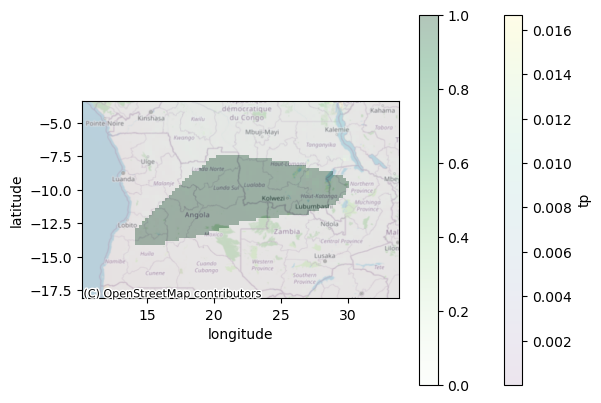

In [65]:
fig, ax = plt.subplots()
bounds = [tavg_window.longitude.values.min(), tavg_window.longitude.values.max(), tavg_window.latitude.values.min(), tavg_window.latitude.values.max()]
tavg_window.plot(ax=ax,alpha=0.1)
da = xr.DataArray(geo_mask, {'latitude': tavg_window.latitude.values, 'longitude': tavg_window.longitude.values})
ctx.add_basemap(ax=ax, crs=tavg_window.rio.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
da.plot(ax=ax,alpha=0.3, cmap="Greens")

In [63]:
tavg_window.rio.crs.to_string()

'EPSG:4326'

In [41]:
x = np.load('nichefrac_column.npy', allow_pickle=True)

In [59]:
# replace None values by inf
x = np.array(x, dtype=float)

(1242,)

# Berkeley Climate Data

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from rasterio.features import rasterize
from datetime import date, timedelta

# plotting
import matplotlib.pyplot as plt
import contextily as ctx
%load_ext autoreload
%autoreload 2

In [2]:
# load and preprocess data 

# load monthly average temperature anomaly from berkeley 
TAVG_monthly = xr.open_dataset("../Data/Berkely_monthly_land/Complete_TAVG_LatLong1.nc")
TMAX_monthly = xr.open_dataset("../Data/Berkely_monthly_land/Complete_TMAX_LatLong1.nc")
TMIN_monthly = xr.open_dataset("../Data/Berkely_monthly_land/Complete_TMIN_LatLong1.nc")

# fix fractional time formate 
def decimal_year_to_date(decimal_year):
    year = int(decimal_year)
    days_in_year = (decimal_year - year) * 365.25
    return pd.to_datetime(f"{year}-01-01") + pd.to_timedelta(days_in_year, unit='D')

# bring avg, min max to same time langth
start_date = TMAX_monthly.time.values[0]
end_date = TMAX_monthly.time.values[-1]
TAVG_monthly = TAVG_monthly.sel(time=slice(start_date, end_date))

# update time coordinate 
TAVG_monthly['time'] = [decimal_year_to_date(t) for t in TAVG_monthly.time.values]
TMAX_monthly['time'] = [decimal_year_to_date(t) for t in TMAX_monthly.time.values]
TMIN_monthly['time'] = [decimal_year_to_date(t) for t in TMIN_monthly.time.values]

# for absolute temperature, add climatology to each month.
months = np.array([date.dt.month for date in TAVG_monthly.time])
tavg = TAVG_monthly.temperature.values + TAVG_monthly.climatology.values[months-1]
tmax = TMAX_monthly.temperature.values + TMAX_monthly.climatology.values[months-1]
tmin = TMIN_monthly.temperature.values + TMIN_monthly.climatology.values[months-1]

# Create the data arrays for tavg, tmax, and tmin
tavg = xr.DataArray(tavg, coords=TAVG_monthly.coords, dims=TAVG_monthly.temperature.dims, name='tavg')
tmax = xr.DataArray(tmax, coords=TMAX_monthly.coords, dims=TMAX_monthly.temperature.dims, name='tmax')
tmin = xr.DataArray(tmin, coords=TMIN_monthly.coords, dims=TMIN_monthly.temperature.dims, name='tmin')

# Concatenate the data arrays into a single dataarray
T = xr.merge([tavg, tmax, tmin])

# write crs to WG84 lon,lat
T = T.rio.write_crs("EPSG:4326")

### Example: Calc Mean annual temperature
Also check if quantiles can be blausibly calculated

In [3]:
#
MAT = T.tavg.groupby('time.year').mean('time')
MAT_1940_1970 = MAT.sel(year=slice(1940,1970)).mean('year')
MAT_1980_2004 = MAT.sel(year=slice(1980,2004)).mean('year')
MAT_2004_2023 = MAT.sel(year=slice(2004,2023)).mean('year')

In [8]:
from utilities_spacial_vars import prep_for_gridcalc, weighted_percentile, calc_percentiles
idx = 2
MAT_window, geo_mask, cell_coefs = prep_for_gridcalc(MAT_1940_1970, gaa2.iloc[[idx]])

# using the values calculated above
percentiles = calc_percentiles([5, 50, 95], MAT_1940_1970, gaa2.iloc[[idx]], geo_mask=geo_mask, cell_coefs=cell_coefs)

# from bottom up
percentiles = calc_percentiles([5, 50, 95], MAT_1940_1970, gaa2.iloc[[idx]])

In [11]:
val = MAT_window.values
w = cell_coefs.values

percentile5 = np.sum(w[val<percentiles[0]]) / np.sum(w)
percentile50 = np.sum(w[val<percentiles[1]]) / np.sum(w)
percentile95 = np.sum(w[val<percentiles[2]]) / np.sum(w)

# plot 
fig, ax = plt.subplots(1,2, figsize=(12,4))
MAT_window.plot(ax=ax[0], cmap='bwr')
da = xr.DataArray(geo_mask, {'latitude': MAT_window.latitude.values, 'longitude': MAT_window.longitude.values})
da.plot(ax=ax[0],alpha=0.8, cmap="Greens")
ax[0].set_title('Species range (green) & MAT (blue-red)')

f = ax[1].hist(val, weights=w)
# f = ax[1].scatter(percentiles, np.zeros(3),color='gray', marker='|', s=1000000)
for i, percentile in enumerate(percentiles):
    ax[1].axvline(percentiles[i], color='gray', linestyle='--', linewidth=2)
    ax[1].text(percentiles[i], 0, str(np.round(percentile,1)), ha='center', va='bottom', fontsize=12)
f = ax[1].set_title('MAT distribution; true perc: ({}, {}, {})'.format(np.round(percentile5,2), np.round(percentile50,2), np.round(percentile95,2)))
f = ax[1].set_xlabel('MAT in °C')
f = ax[1].set_ylabel('Area in arbitrary units')


AttributeError: 'numpy.ndarray' object has no attribute 'values'

# Compare temperature consistency of berkeley earth data and ERA5.

In [209]:
# global correlation mean T 1980 - 2020
T_ERA5 = ERA5.t2m.sel(time=slice(date(1980,1,1), date(2000,12,31))).mean(dim='time') - 273.15
T_Berk = T.tavg.sel(time=slice(date(1980,1,1), date(2000,12,31))).mean(dim='time')

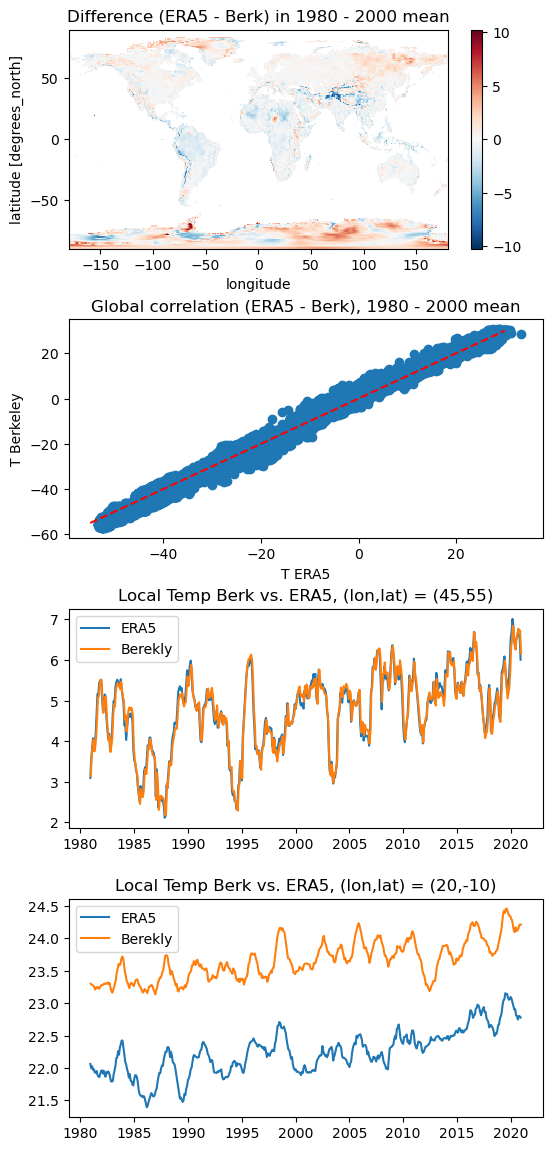

In [258]:
# compare temperature consistency of berkeley earth data and ERA5.
fig, ax = plt.subplots(4,1, figsize=(6,12))
fig.tight_layout(pad=3)


T_ERA5_selected = T_ERA5.sel(latitude = T_Berk.latitude, longitude = T_Berk.longitude, method='nearest')[0].where(~T_Berk.isnull())
T_diff = T_ERA5_selected - T_Berk
T_diff.plot(ax=ax[0])
ax[0].set_title('Difference (ERA5 - Berk) in 1980 - 2000 mean')

ax[1].scatter(T_ERA5_selected.values, T_Berk.values)
ax[1].plot(np.arange(-55,35,5), np.arange(-55,35,5),color='r', ls='--')
ax[1].set_xlabel('T ERA5')
ax[1].set_ylabel('T Berkeley')
ax[1].set_title('Global correlation (ERA5 - Berk), 1980 - 2000 mean')

# (from 1980 to 2020)
lonobs = 45
latobs = 55
T_ERA5_pt = ERA5.t2m.sel(time=slice(date(1980,1,1), date(2020,12,31))).sel(
    longitude=lonobs, latitude=latobs).rolling(time=12).mean() - 273.15
T_Berk_pt = T.tavg.sel(time=slice(date(1980,1,1), date(2020,12,31))).sel(
    longitude=lonobs, latitude=latobs, method='nearest').rolling(time=12).mean()
ax[2].plot(T_ERA5_pt.time, T_ERA5_pt.values[:,0], label='ERA5')
ax[2].plot(T_Berk_pt.time,T_Berk_pt.values, label='Berekly')
ax[2].set_title('Local Temp Berk vs. ERA5, (lon,lat) = ({},{})'.format(lonobs, latobs))
ax[2].legend()


# (from 1980 to 2020)
lonobs = 20
latobs = -10
T_ERA5_pt = ERA5.t2m.sel(time=slice(date(1980,1,1), date(2020,12,31))).sel(
    longitude=lonobs, latitude=latobs).rolling(time=12).mean() - 273.15
T_Berk_pt = T.tavg.sel(time=slice(date(1980,1,1), date(2020,12,31))).sel(
    longitude=lonobs, latitude=latobs, method='nearest').rolling(time=12).mean()
ax[3].plot(T_ERA5_pt.time, T_ERA5_pt.values[:,0], label='ERA5')
ax[3].plot(T_Berk_pt.time, T_Berk_pt.values, label='Berekly')
ax[3].set_title('Local Temp Berk vs. ERA5, (lon,lat) = ({},{})'.format(lonobs, latobs))
ax[3].legend()


# !!! Always double check resampling !!! This one does not work.
from rasterio.enums import Resampling
T_ERA5_dnsampled = T_ERA5.rio.reproject(
    T_ERA5.rio.crs,
    shape=(T_Berk.rio.height, T_Berk.rio.width),
    resampling=Resampling.bilinear,)
# !!!

It seems that there are quite big spacial differences in temperatures between the two datasets. In particular, ERA5 estimates much higher temperatures for high latitudes and much lower temperatures for lower latitudes, compared to the Berkely earth reconstruction.

The ERA5 reconstruction is the more reliable source. Since the monthly mean of max daily temperatures is not included in the monthly average dataset. I will use the berkely earth data for now and derive these quantities from daily data later on.

# Raster spacial Data

In [4]:
# script_test = pd.read_csv('gaa2_landuse_2021.csv')

here :  0.0223202300139491


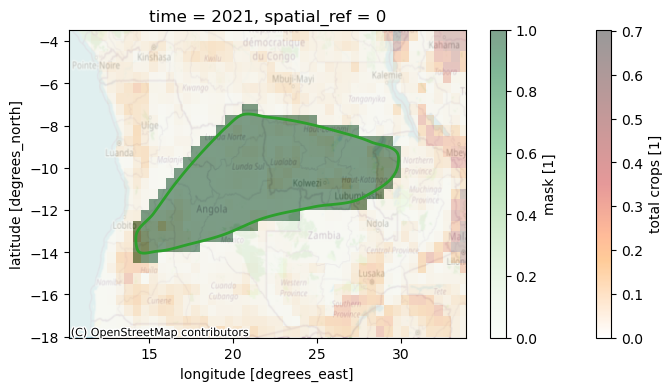

In [8]:
idx = 4
# load test geometry
geo = gaa2.iloc[[idx]]

# get the fractional cropland cover for the window of the geometry
margin = 4
xmin, ymin, xmax, ymax = geo.bounds.values[0]
xmin -= margin
ymin -= margin
xmax += margin
ymax += margin

crop21 = crop.sel(time=2021).cropland_total
dat_window = crop21.sel(lon = slice(xmin, xmax), lat = slice(ymax, ymin))

# Rasterize the polygon according to window
poly = geo['geometry'].iloc[0]
poly_mask = rasterize([(poly)],
                transform=dat_window.rio.transform(),
                out_shape=dat_window.shape, 
                all_touched=True)


# calculate the percentage of range size covered by crops
## weight data cells by grid cell size
from numpy import pi, cos

dat_window = dat_window.fillna(0)
lats = np.expand_dims(dat_window.lat,axis=1) / 360 * 2 * pi
cell_coefs = cos(lats)
dat_wheighted = dat_window.values * cell_coefs

## perform calculation
cropcover_percentage = np.sum(poly_mask * dat_wheighted) / np.sum(poly_mask * cell_coefs)

print('here : ', cropcover_percentage)
# print('script: ', script_test.cropland_2021.iloc[idx])



# Visualize
## copy array to xarray with appropiate coordinates and crs (improvised version)
mask2 = dat_window.copy()
mask2.attrs['long_name'] = 'mask'
mask2.values = poly_mask

## plot
fig, ax = plt.subplots(figsize=(8,4))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
geo.plot(ax=ax, facecolor='none', edgecolor='tab:green', linewidth=2)
ctx.add_basemap(ax=ax, crs=geo.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
dat_window.plot.imshow(ax=ax, alpha = 0.4, cmap='gist_heat_r')
mask2.plot.imshow(ax=ax, alpha= 0.5, cmap='Greens')

In [ ]:
# get rows of climate change spec

# Visualize dataset

In [15]:
pred2022_hf_c = pd.read_csv('pred2022.csv')
pred2022_hf_c.keys()

Index(['Unnamed: 0', 'Species Name', 'Order', 'Family', 'Species Name_x',
       '2004 GAA2 Red List Category', '2022 GAA2 Red List Category',
       '2022 Red List Criteria', '2004-2022 Genuine Change?',
       ' 2004-2022 Primary Driver', 'Grouped 2004-2022 Primary Driver',
       '2004-2022 Genuine downlisting due to conservation', 'Afrotropical',
       'Australasian/Oceanian', 'Indomalayan', 'Nearctic', 'Neotropical',
       'Palearctic', 'Egg Laying', 'Free Living Larval Stage', 'Live Birth ',
       'Water Breeding', 'N_realm', '2004 RL num', '2022 RL num',
       'higher risk', 'urbanareas_2021', 'cropland_2021', 'rangeland_2021',
       'managed_pasture_2021', 'urbanareas_2021_change',
       'cropland_2021_change', 'rangeland_2021_change',
       'managed_pasture_2021_change', 'area_2021', 'MAT_nichefrac_2022',
       'MAT_2022', 'MAT_change_2022', 'MTWM_nichefrac_2022', 'MTWM_2022',
       'MTWM_change_2022', 'MTCM_nichefrac_2022', 'MTCM_2022',
       'MTCM_change_2022', 'AP

25%: 0.1 1e5
50%: 0.34 1e5
75%: 1.57 1e5


Text(0, 0.5, 'Number of species')

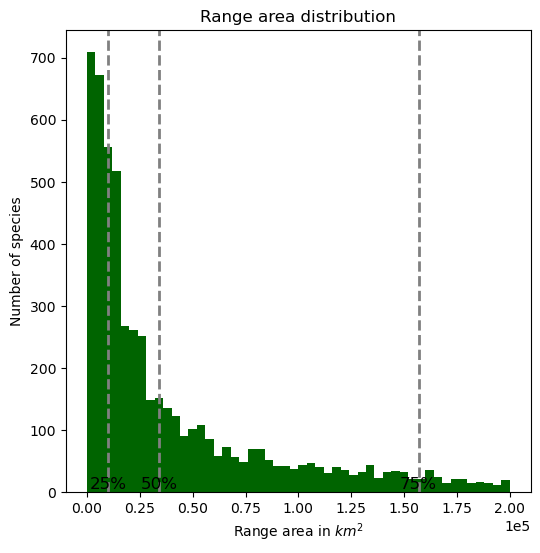

In [16]:
# plot histogram of range areas
# calc percentiles
percentiles = np.percentile(pred2022_hf_c['area_2021'], [25, 50, 75])
# print percentiles as coefficient to 1e5
print('25%:', np.round(percentiles[0] / 1e5,2), '1e5')
print('50%:', np.round(percentiles[1] / 1e5,2), '1e5')
print('75%:', np.round(percentiles[2] / 1e5,2), '1e5')


fig, ax = plt.subplots(1,1, figsize=(6,6))
g = ax.hist(pred2022_hf_c['area_2021'], bins=50, range=(0, 2 * 1e5), color='darkgreen')
# plot x in scientific notation
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
# plot percentiles
q = ["25%", "50%", "75%"]
for i, percentile in enumerate(percentiles):
    ax.axvline(percentile, color='gray', linestyle='--', linewidth=2)
    ax.text(percentile, 0, q[i], ha='center', va='bottom', fontsize=12)
ax.set_title('Range area distribution')
ax.set_xlabel('Range area in $km^2$')
ax.set_ylabel('Number of species')

In [17]:
import seaborn as sns
# dataset = pred2022_hf_c.loc[:, ['higher risk','area_2021', 'urbanareas_2021_change', 'PDQ_change_column_2022', 'PDQ_change_nichefrac_2022', 'AP_change_column_2022']]
# dataset = pred2022_hf_c.loc[:, ['2004 RL num', 'higher risk',
#        'urbanareas_2021', 'cropland_2021', 'rangeland_2021','urbanareas_2021_change',
#        'cropland_2021_change', 'rangeland_2021_change', 'area_2021', 'MAT_nichefrac_2022',
#        'MAT_column_2022', 'MAT_change_column_2022', 'MTWM_nichefrac_2022',
#        'MTWM_column_2022', 'MTWM_change_column_2022', 'MTCM_nichefrac_2022',
#        'MTCM_column_2022', 'MTCM_change_column_2022', 'AP_nichefrac_2022',
#        'AP_column_2022', 'AP_change_column_2022', 'PDQ_nichefrac_2022',
#        'PDQ_column_2022', 'PDQ_change_column_2022',
#        'MAT_change_nichefrac_2022', 'MTWM_change_nichefrac_2022',
#        'MTCM_change_nichefrac_2022', 'AP_change_nichefrac_2022',
#        'PDQ_change_nichefrac_2022']]

dataset = pred2022_hf_c[['MAT_2022', 'MAT_change_2022', 'MTWM_nichefrac_2022', 'MTWM_2022',
       'MTWM_change_2022', 'MTCM_nichefrac_2022', 'MTCM_2022',
       'MTCM_change_2022', 'AP_nichefrac_2022', 'AP_2022', 'AP_change_2022',
       'PDQ_nichefrac_2022', 'PDQ_2022', 'PDQ_change_2022', 'higher risk']]


<Axes: >

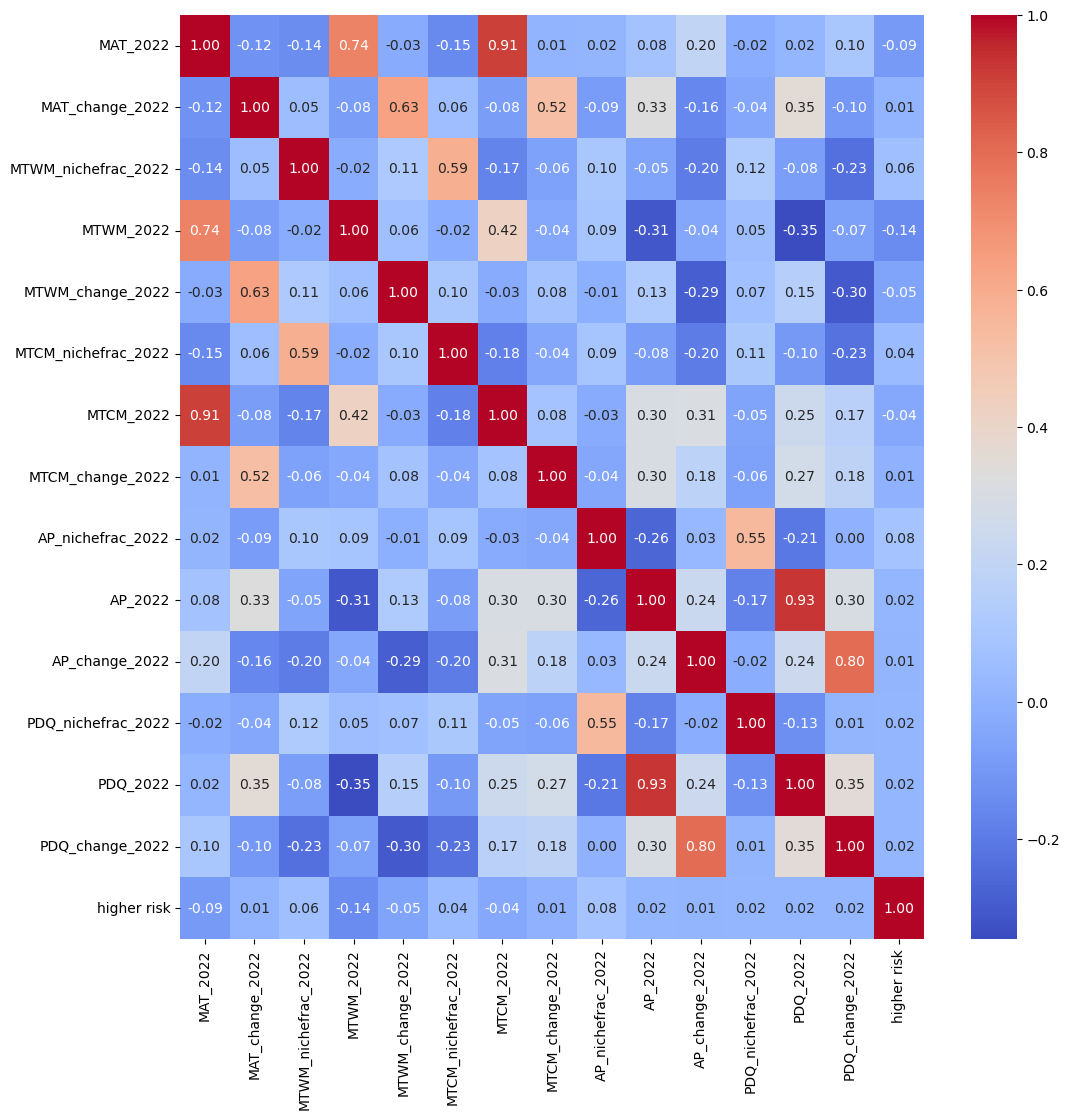

In [18]:
# plot corellation matrix
corr = dataset.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)

Threshold: 0.4
Variable: MAT | Count: 0 | High risk of those: 0 | In percent: nan
Variable: AP | Count: 0 | High risk of those: 0 | In percent: nan
Variable: PDQ | Count: 4 | High risk of those: 4 | In percent: 100.0
Threshold: 0.5
Variable: MAT | Count: 0 | High risk of those: 0 | In percent: nan
Variable: AP | Count: 2 | High risk of those: 0 | In percent: 0.0
Variable: PDQ | Count: 9 | High risk of those: 6 | In percent: 66.67
Threshold: 0.6
Variable: MAT | Count: 5 | High risk of those: 0 | In percent: 0.0
Variable: AP | Count: 4 | High risk of those: 0 | In percent: 0.0
Variable: PDQ | Count: 16 | High risk of those: 8 | In percent: 50.0
Threshold: 0.7
Variable: MAT | Count: 26 | High risk of those: 4 | In percent: 15.38
Variable: AP | Count: 15 | High risk of those: 2 | In percent: 13.33
Variable: PDQ | Count: 35 | High risk of those: 15 | In percent: 42.86
Threshold: 0.8
Variable: MAT | Count: 63 | High risk of those: 5 | In percent: 7.94
Variable: AP | Count: 55 | High risk of 

C:\Users\Claus\AppData\Local\Temp\ipykernel_28008\263691433.py:16: RuntimeWarning: invalid value encountered in scalar divide
  percentage = round(count/len(nicheloosers)*100,2)


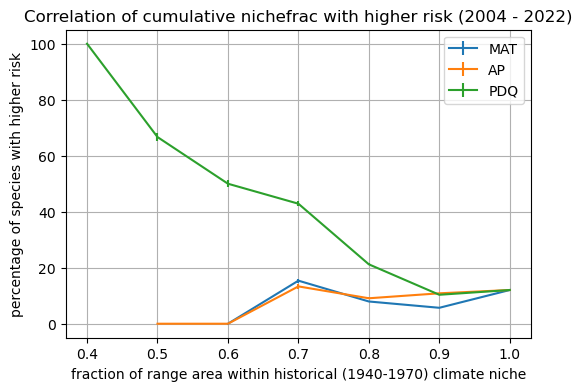

In [19]:
# reproduce corellation graphic with climate variables

var_codes = ['MAT', 'AP', 'PDQ']
# dict with percentages
percentages_vars = {var_code:[] for var_code in var_codes}
percentages_err_vars = {var_code:[] for var_code in var_codes}

for thesh in np.round(np.arange(0.4, 1.05, 0.1),1):
    print('Threshold:', thesh)
    for var_code in var_codes:
        # get list with species names with niche fraction less than thesh
        nicheloosers = pred2022_hf_c.loc[(pred2022_hf_c[var_code + '_nichefrac_2022'].values) <= thesh]

        # calc percentage of those that have a genuine change
        count = nicheloosers['higher risk'].sum()
        percentage = round(count/len(nicheloosers)*100,2)
        percentages_vars[var_code].append(percentage)
        percentages_variance = percentage / 100 * (1 - percentage / 100) / len(nicheloosers) * 100
        percentages_err_vars[var_code].append(np.sqrt(percentages_variance))
        print(f'Variable: {var_code} | Count: {len(nicheloosers)} | High risk of those: {count} | In percent: {percentage}')

# plot histogram for each variable
fig, ax = plt.subplots(1,1, figsize=(6,4))
for var_code in var_codes:
    ax.errorbar(np.round(np.arange(0.4, 1.05, 0.1),1), percentages_vars[var_code], yerr = percentages_err_vars[var_code], label=var_code)
    ax.legend()
    ax.grid()
    ax.set_title('Correlation of cumulative nichefrac with higher risk (2004 - 2022)')
    ax.set_xlabel('fraction of range area within historical (1940-1970) climate niche')
    ax.set_ylabel('percentage of species with higher risk')	

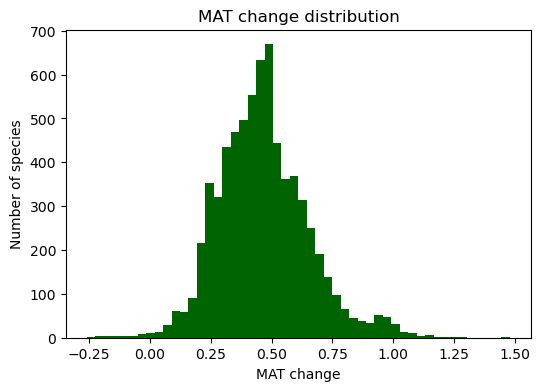

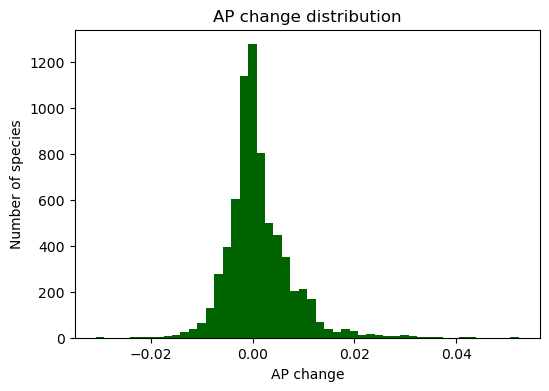

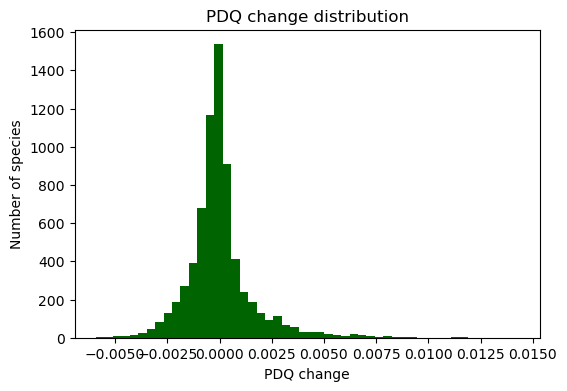

In [20]:
# plot histogram of variable changes
var_codes = ['MAT', 'AP', 'PDQ']

for var in var_codes:
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    g = ax.hist(pred2022_hf_c[var + '_change_2022'], bins=50, color='darkgreen')
    ax.set_title(f'{var} change distribution')
    ax.set_xlabel(f'{var} change')
    ax.set_ylabel('Number of species')

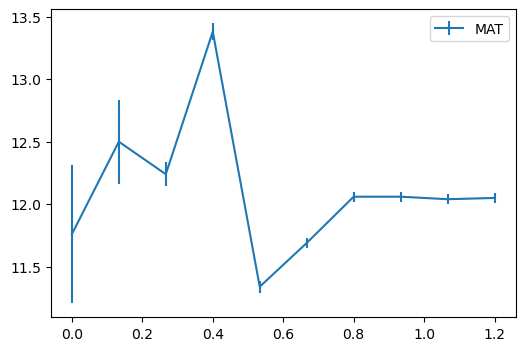

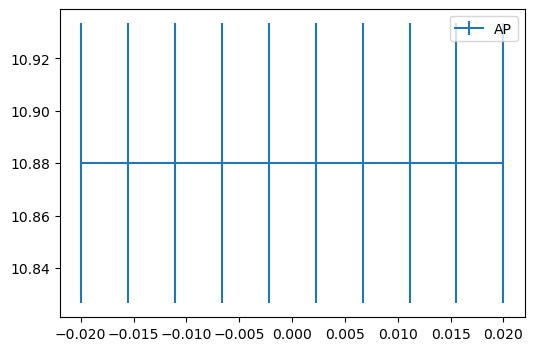

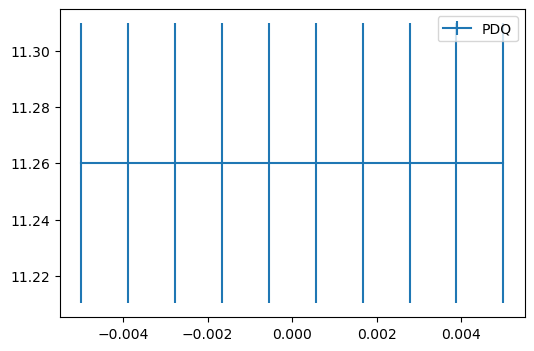

In [21]:
# reproduce corellation graphic with climate variables

var_codes = ['MAT', 'AP', 'PDQ']
# dict with percentages
change_vars = {var_code:[] for var_code in var_codes}
change_err_vars = {var_code:[] for var_code in var_codes}
bins_vars = {"MAT": np.linspace(0, 1.2, 10), "AP": np.linspace(-0.02, 0.02, 10), "PDQ": np.linspace(-0.005, 0.005, 10)}

for var_code in var_codes:
    for thesh in np.round(bins_vars[var_code],1):
        # calc percentage of nicheloosers (now species with temperature change more than thesh)
        nicheloosers = pred2022_hf_c.loc[(pred2022_hf_c[var_code + '_change_2022'].values) <= thesh]
        
        # calc percentage of those that have a genuine change
        count = nicheloosers['higher risk'].sum()
        percentage = round(count/len(nicheloosers)*100,2)
        change_vars[var_code].append(percentage)
        variance = percentage / 100 * (1 - percentage / 100) / len(nicheloosers) * 100
        change_err_vars[var_code].append(np.sqrt(variance))
        # print(f'Variable: {var_code} | Count: {len(nicheloosers)} | High risk of those: {count} | In percent: {percentage}')

# plot errorbar for each variable, share x axis
for var_code in var_codes:
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.errorbar(bins_vars[var_code], change_vars[var_code], yerr= change_err_vars[var_code], label=var_code)
    ax.legend()


In [26]:
dataset = pred2022_hf_c.loc[:, ['higher risk', 'MAT_nichefrac_2022', 'MAT_2022', 'MAT_change_2022',
       'MTWM_nichefrac_2022', 'MTWM_2022', 'MTWM_change_2022',
       'MTCM_nichefrac_2022', 'MTCM_2022', 'MTCM_change_2022',
       'AP_nichefrac_2022', 'AP_2022', 'AP_change_2022',
       'PDQ_nichefrac_2022', 'PDQ_2022', 'PDQ_change_2022']]

bins = np.arange(0,1.1,0.1)
# for 'MAT_nichefrac_2022' in bins, calculate the percentage of species with "higher risk"



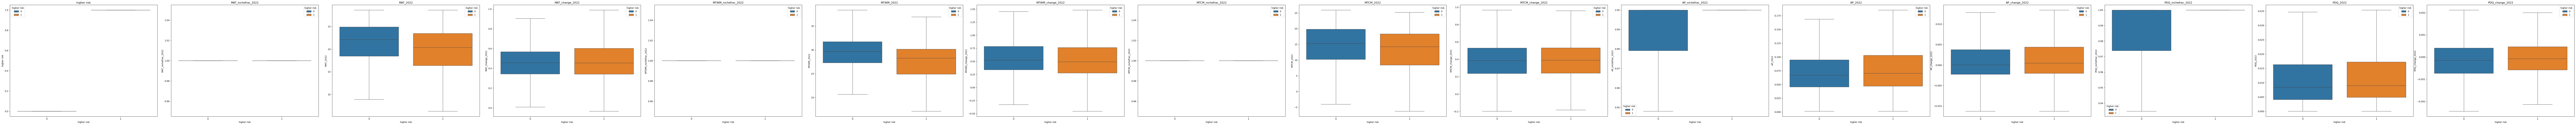

In [27]:
# do boxplots for all variables in dataset, dependent on hue = higher risk
fig, ax = plt.subplots(1,dataset.shape[1], figsize=(160,8))
fig.tight_layout(pad=3)
for i, col in enumerate(dataset.columns):
    sns.boxplot(x='higher risk', y=col, data=dataset, hue='higher risk', ax=ax[i], showfliers=False)
    ax[i].set_title(col)
    # log y axis
    # ax[i].set_yscale('log')